In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
#from astroquery.lamda import Lamda
exec(open("./cyllindric_V.py").read())


In [2]:
#parameters for the emission surface
h0 = 0.3
psi = 1.0

#ray tracing parameters
th = np.pi / 30.0
ph = 0.0



In [3]:
#parameters for the ray-tracing

rc = 50.0  #we consider deprojected radius 50 AU
#and 201 azimuthal points
res = 201  
psi_var = np.arange(res)*2.0*np.pi/(res)

#this corresponds to plane of the sky projected coordinates
x_POS = np.zeros((1,res))
y_POS = np.zeros((1,res))
x_POS[0,:] = np.cos(psi_var-ph)*rc
y_POS[0,:] = np.sin(psi_var-ph)*np.cos(th)*rc


In [4]:
rvec = np.linspace(0.0,200.0,num=50)   #2D axisymmetric grid we work on

Td = np.load('./data/Td_calahan.npy')                #dust temperature
Td = Td[0:100:2,0]       #only the midplane


We read out the converged output from LIME simulations and perform our ray-tracing using them. We read out
    (i) number density
    (ii) gas temperature
    (iii) abundance
    (iv) CN number density
    (v) CN level populations
for the emission surface, as a function of cyllindrical radius and for different simulations. Simulations were performed assuming high/medium/low optical depth and an upper/lower emission surface at h=0.3 or h=0.1 at rc=50 AU.

Besides these properties, we read out molecular constants
    (i) Einstein coefficients of the transitions
    (ii) frequencies of the transitions
    (iii) upper level numbers of the transitions
    (iv) lower level numbers of the transitions
    (v) state degeneracies
    (vi) lower level Zeeman parameters
    (vii) upper level Zeeman paramteers
    (viii) lower level angular momenta
    (ix) upper level angular momenta

In [5]:
x='low'
z='upper'

nH = np.load('./data/'+x+'/'+z+'/nH_surf.npy')           #number density
Tg = np.load('./data/'+x+'/'+z+'/Tg_surf.npy')           #number density
ab = np.load('./data/'+x+'/'+z+'/ab_surf.npy')           #number density
nCO= np.load('./data/'+x+'/'+z+'/nmol_surf.npy')           #number density
N_ = np.load('./data/'+x+'/'+z+'/N_surf.npy')           #number density
#out = dir_+'summary_50/'+x+'/'+z+'/'
#
A   = np.load('./data/A.npy')
nu  = np.load('./data/nu.npy')
iu  = np.load('./data/iu.npy')   #make sure these are integers
il  = np.load('./data/il.npy')   #make sure these are integers
g   = np.load('./data/g.npy')
xl = np.load('./data/xl.npy')
xu = np.load('./data/xu.npy')
jl = np.load('./data/jl.npy')
ju = np.load('./data/ju.npy')
#
b = get_b(Tg,26.0,50.0)            #turbulence + thermal width
Nl = np.multiply(nCO,N_[il,:])   #lower level populations / degeneracy
Nu = np.multiply(nCO,N_[iu,:])   #upper level populations / degeneracy
Su = source_fun(Nl,Nu)             #source functions (in photon occupancy units)
Su = np.nan_to_num(Su)     #if nan, we set it 0
tau = np.divide(rad_fac_pop_au(A,nu,np.subtract(Nl,Nu)),np.multiply(b,np.sqrt(np.pi)))    #tau / AU
B0 = background_rad_norm(nu)       #background radiation field (in photon occupancy units)

#               
tau = 0.1*rvec*tau / np.cos(np.pi/30.0)
#               
tau_dust,Sd = prop_dust(rvec,Td,3)
vr = np.linspace(-2e3,2e3,2001)
#

<string>:405: RuntimeWarning: invalid value encountered in divide
<string>:651: RuntimeWarning: divide by zero encountered in power
<string>:89: RuntimeWarning: divide by zero encountered in divide


In [6]:
#run simulation without dust midplane
I_im,Q_im,U_im,V_im,I0_im = get_image(x_POS,y_POS,th,ph,rvec,tau,Su,b,tau_dust,Sd,xl,xu,jl,ju,vr,B0,h0,psi,False)
#run simulation with dust midplane
Id_im,Qd_im,Ud_im,Vd_im,Id0_im = get_image(x_POS,y_POS,th,ph,rvec,tau,Su,b,tau_dust,Sd,xl,xu,jl,ju,vr,B0,h0,psi,True)

In [7]:
#continuum subtraction
I = I_im
I0 = I0_im
Id = Id_im
Id0 = Id0_im

Q = Q_im
Qd = Qd_im
U = U_im
Ud = Ud_im
V = V_im
Vd = Vd_im

for i in range(9):
    for i_psi in range(np.shape(I)[-1]):
        I[i,:,0,i_psi] -= np.amin(I[i,:,0,i_psi])
        I0[i,:,0,i_psi] -= np.amin(I0[i,:,0,i_psi])
        Id[i,:,0,i_psi] -= np.amin(Id[i,:,0,i_psi])
        Id0[i,:,0,i_psi] -= np.amin(Id0[i,:,0,i_psi])


In [8]:
#polarization fractions and angles
pL = np.sqrt(np.square(Q) + np.square(U))
pLd= np.sqrt(np.square(Qd) + np.square(Ud))

eta = 0.5*np.arctan2(U,Q)
etad= 0.5*np.arctan2(Ud,Qd)


In [9]:
#some functions to obtain the FWHM and the polarization fractions

def get_FWHM_gauss(x,I):
    I0 = np.trapz(x,I)
    x0 = np.trapz(x,x*I/I0)
    b  = np.sqrt(2.0*np.trapz(x,np.square(x-x0)*I/I0))
    return 2.0*np.sqrt(np.log(2.0))*b

def get_FWHM(x,I):
#input:
#x      : x-coordinate
#I      : intensity function that needs to be fitted
#
#output:
#       : FWHM of I
#
#position of maximum
  x_max = np.argmax(I)
#compute half maximum
  Im2 = 0.5 * I[x_max]
#search for the half of the maximum right and left of the maximum
  xm2_r = np.interp(-Im2,-I[x_max:-1],x[x_max:-1])  #minus sign so that I is an ascending function
  xm2_l = np.interp(Im2,I[0:x_max],x[0:x_max])
  return xm2_r-xm2_l

#compute the pV = 0.5*(V_max-V_min / I_max)
def get_pV(I,V):
#input:
#I,V    : Stokes parameters of total intensity and circular polarization
#
#output:
#       : pV = 0.5*(V_max-V_min / I_max)
#
  I_max = np.amax(I)
#
  V_max = np.amax(V)
  V_min = np.amin(V)
#
  return np.divide(np.subtract(V_max,V_min),np.multiply(I_max,2.0))

#compute the Q,U at maximum
def get_QU(I,V):
#input:
#I,V    : Stokes parameters of total intensity and circular polarization
#
#output:
#       : pV = 0.5*(V_max-V_min / I_max)
#
#position of maximum
  x_max = np.argmax(I)
#
  return V[x_max] / I[x_max]


In [10]:
wI = np.zeros((9,np.shape(I)[-1]))       #widths computed using search method
wI0 = np.zeros((9,np.shape(I)[-1]))
wgI = np.zeros((9,np.shape(I)[-1]))       #widths computed using Gaussian method
wgI0 = np.zeros((9,np.shape(I)[-1]))

wId = np.zeros((9,np.shape(I)[-1]))       #widths computed using search method
wId0 = np.zeros((9,np.shape(I)[-1]))
wgId = np.zeros((9,np.shape(I)[-1]))       #widths computed using Gaussian method
wgId0 = np.zeros((9,np.shape(I)[-1]))

pV = np.zeros((9,np.shape(I)[-1]))       #circular polarization fraction
pVd = np.zeros((9,np.shape(I)[-1]))

pQ = np.zeros((9,np.shape(I)[-1]))       #linear polarization fractions
pQd = np.zeros((9,np.shape(I)[-1]))
pU = np.zeros((9,np.shape(I)[-1]))       #
pUd = np.zeros((9,np.shape(I)[-1]))


for i in range(9):
    for i_psi in range(np.shape(I)[-1]):
            wgI[i,i_psi] = get_FWHM_gauss(vr,I[i,:,0,i_psi])
            wgI0[i,i_psi] = get_FWHM_gauss(vr,I0[i,:,0,i_psi])
            wgId[i,i_psi] = get_FWHM_gauss(vr,Id[i,:,0,i_psi])
            wgId0[i,i_psi] = get_FWHM_gauss(vr,Id0[i,:,0,i_psi])
#
            wI[i,i_psi] = get_FWHM(vr,I[i,:,0,i_psi])
            wI0[i,i_psi] = get_FWHM(vr,I0[i,:,0,i_psi])
            wId[i,i_psi] = get_FWHM(vr,Id[i,:,0,i_psi])
            wId0[i,i_psi] = get_FWHM(vr,Id0[i,:,0,i_psi])
#
            pV[i,i_psi] = get_pV(I[i,:,0,i_psi],V[i,:,0,i_psi])
            pVd[i,i_psi] = get_pV(Id[i,:,0,i_psi],Vd[i,:,0,i_psi])
#
            pQ[i,i_psi] = get_QU(I[i,:,0,i_psi],Q[i,:,0,i_psi])
            pQd[i,i_psi] = get_QU(Id[i,:,0,i_psi],Qd[i,:,0,i_psi])
            pU[i,i_psi] = get_QU(I[i,:,0,i_psi],U[i,:,0,i_psi])
            pUd[i,i_psi] = get_QU(Id[i,:,0,i_psi],Ud[i,:,0,i_psi])


In [11]:
#analytical total/toroidal/vertical Zeeman splitting coefficients
xZ   = 0.15 * (2.18/2.0) * (25.0127967 / 10.0) / ( (185.84 / 200.0) * (113.14416 / 100.0) )
xZ_t = 0.15 * (2.18/2.0) * (25.0 / 10.0) / ( (185.84 / 200.0) * (113.14416 / 100.0) )
xZ_z = 0.15 * (2.18/2.0) * (0.8 / 10.0) / ( (185.84 / 200.0) * (113.14416 / 100.0) )



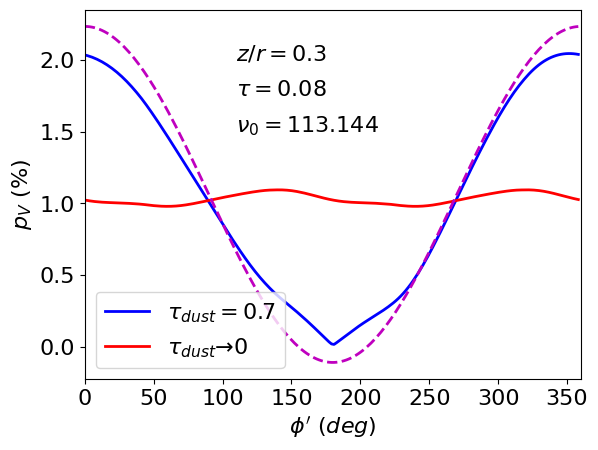

In [12]:
#Figure 6
#
pV_z = np.sqrt(2.0 / np.exp(1.0)) * xZ_z * np.cos(np.pi/30.0)
pVd_fit = pV_z * (1.0 + 25.0/0.8 * np.tan(np.pi/30.0) * np.cos(psi_var) * np.tanh(0.7/2.0))

plt.plot(psi_var*180.0/np.pi,100.0*pVd[0,:],linewidth=2,color='b',label='$\\tau_{dust}=0.7$')
plt.plot(psi_var*180.0/np.pi,100.0*pV[0,:],linewidth=2,color='r',label='$\\tau_{dust} \\to 0$')

plt.xlabel('$\\phi \' \\ (deg) $',fontsize=16)
plt.ylabel('$p_V \\ (\\%)$',fontsize=16)
plt.legend(loc='lower left',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.text(110.0,2.0,'$z/r=0.3$',fontsize=16)
plt.text(110.0,1.75,'$\\tau=0.08$',fontsize=16)
plt.text(110.0,1.5,'$\\nu_0=113.144$',fontsize=16)

plt.xlim([0.0,360.0])

plt.plot(psi_var*180.0/np.pi,100.0*pVd_fit,linewidth=2,color='m',linestyle='dashed',label='$p_V^z + p_V^t tanh \\tau_{dust}/2$')
#plt.legend(loc='upper right',fontsize=16)

plt.savefig('./figures/var_pV.png', bbox_inches='tight')

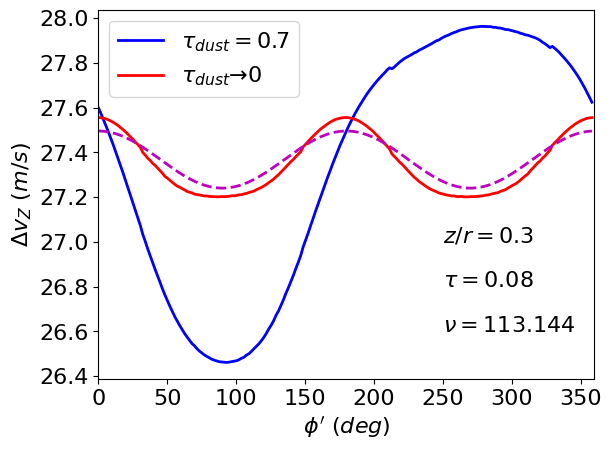

In [13]:
#Figure 8
plt.plot(psi_var*180.0/np.pi,wId[0,:]-wId0[0,:],linewidth=2,color='b',label='$\\tau_{dust}=0.7$')
plt.plot(psi_var*180.0/np.pi,wI[0,:]-wI0[0,:],linewidth=2,color='r',label='$\\tau_{dust} \\to 0$')

#plt.plot(psi*180.0/np.pi,wgId[4,0,:]-wgId0[4,0,:],linewidth=2,color='b',label='$\\tau_{dust}=0.7$')
#plt.plot(psi*180.0/np.pi,wgI[4,0,:]-wgI0[4,0,:],linewidth=2,color='r',label='$\\tau_{dust} \\to 0$')

plt.xlabel('$\phi \' \\ (deg) $',fontsize=16)
plt.ylabel('$\Delta v_Z \\ (m/s)$',fontsize=16)
plt.legend(loc='upper left',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

Qbar = 1.14
dQ   = -0.98

#pw_fit = 27.15 + 0.35*np.square(np.cos(psi))
bv = 0.8/25.0127967
bt = 25.0/25.0127967
cth2 = np.cos(np.pi/30.0) * np.cos(np.pi/30.0)
sth2 = np.sin(np.pi/30.0) * np.sin(np.pi/30.0)
pw_fit = 0.84 * xZ * xZ * (Qbar - dQ * (bv*bv*cth2 + bt*bt*sth2*np.cos(psi_var)*np.cos(psi_var)) )
#pw_fit_ana = 185.84 * ( 0.84 * xZ * xZ * (Qbar - dQ * (bv*bv*cth2 + bt*bt*sth2*np.cos(psi)*np.cos(psi)) ))
pw_fit_ana = 185.84 * ( 0.849 * xZ * xZ * (Qbar - dQ * (bv*bv*cth2 + bt*bt*sth2*np.cos(psi_var)*np.cos(psi_var)) ))

#plt.plot(psi*180.0/np.pi,pw_fit,linewidth=2,color='m',linestyle='dashed')
plt.plot(psi_var*180.0/np.pi,pw_fit_ana,linewidth=2,color='m',linestyle='dashed')

plt.text(250.0,0.6+26.4,'$z/r=0.3$',fontsize=16)
plt.text(250.0,0.6+26.2,'$\\tau=0.08$',fontsize=16)
plt.text(250.0,0.6+26.0,'$\\nu=113.144$',fontsize=16)

plt.xlim([0.0,360.0])

#plt.plot(psi*180.0/np.pi,100.0*pVd_fit,linewidth=2,color='b',linestyle='dashed',label='$p_V^z + p_V^t tanh \\tau_{dust}/2$')
#plt.legend(loc='upper right',fontsize=16)

plt.savefig('./figures/var_broad_fit.png', bbox_inches='tight')


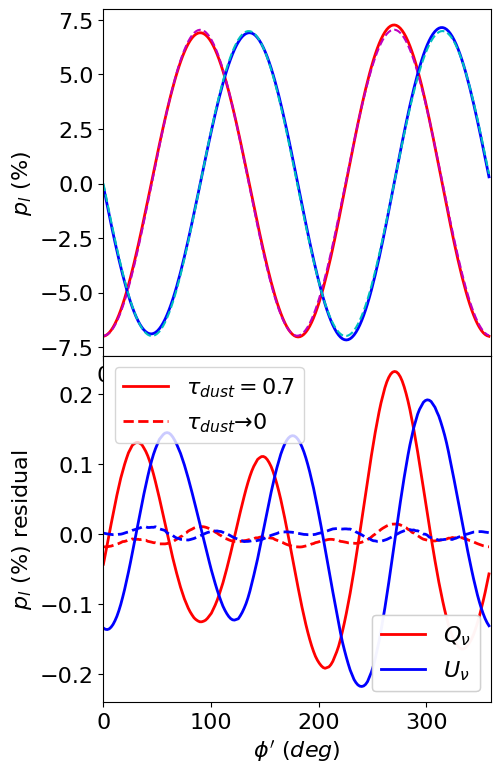

In [14]:
#Figure 10
fig = plt.figure(figsize=(5,9))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 2])

ax0 = plt.subplot(gs[0])
ax0.plot(psi_var*180.0/np.pi,100.0*pQd[0,:],linewidth=2,color='r')
ax0.plot(psi_var*180.0/np.pi,100.0*pQ[0,:],linewidth=1.5,color='m',linestyle='dashed')
ax0.plot(psi_var*180.0/np.pi,100.0*pUd[0,:],linewidth=2,color='b')
ax0.plot(psi_var*180.0/np.pi,100.0*pU[0,:],linewidth=1.5,color='c',linestyle='dashed')

ax0.set_ylabel('$p_l \\ (\\%)$',fontsize=16)
#plt.legend(loc='lower left',fontsize=16)
ax0.tick_params(labelsize=16)

#ax0.text(230.0,6.0,'$z/r=0.3$',fontsize=16)
#ax0.text(230.0,5.0,'$\\tau=0.08$',fontsize=16)
#ax0.text(230.0,4.0,'$\\nu=113.144$',fontsize=16)

f = 0.95

pQ_fit_ana = -f*xZ*xZ*dQ/2.0 * (-bv*bv*sth2 - bt*bt*(np.cos(2.0*psi_var)-sth2*np.cos(psi_var)*np.cos(psi_var)))
pU_fit_ana = -f*xZ*xZ*dQ/2.0 * (- bt*bt*(np.cos(th)*np.sin(2.0*psi_var)))


ax1 = plt.subplot(gs[1])
ax1.plot(psi_var*180.0/np.pi,100.0*(pQd[0,:]-pQ_fit_ana),linewidth=2,color='r')
ax1.plot(psi_var*180.0/np.pi,100.0*(pQ[0,:]-pQ_fit_ana),linewidth=2,color='r',linestyle='dashed')
ax1.plot(psi_var*180.0/np.pi,100.0*(pUd[0,:]-pU_fit_ana),linewidth=2,color='b')
ax1.plot(psi_var*180.0/np.pi,100.0*(pU[0,:]-pU_fit_ana),linewidth=2,color='b',linestyle='dashed')

ax1.set_xlabel('$\phi \' \\ (deg) $',fontsize=16)
ax1.set_ylabel('$p_l\\ (\\%)\\ \\mathrm{residual}$',fontsize=16)
ax1.tick_params(labelsize=16)
ax0.set_xlim([0,360.0])
ax1.set_xlim([0,360.0])

lines = ax1.get_lines()
legend1=plt.legend([lines[i] for i in [0,1]],['$\\tau_{dust}=0.7$','$\\tau_{dust} \\to 0$'],fontsize=16,loc='upper left')
legend2=plt.legend([lines[i] for i in [0,2]],['$Q_{\\nu}$','$U_{\\nu}$'],fontsize=16,loc='lower right')
ax1.add_artist(legend1)
ax1.add_artist(legend2)

plt.subplots_adjust(hspace=.0)

plt.savefig('./figures/stokes_QU_psi.png', bbox_inches='tight')
